In [1]:
import os
import glob
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv("metal_lyrics.csv")
death = data[data["Artist"] == "BATHORY"]
death

,Artist,Album,Song,Lyric,SongNum,Year
27188,BATHORY,Bathory,Storm Of Damnation,\n,1,1984
27189,BATHORY,Bathory,Hades,Beyond the mountains\nwhere the wind cries out...,2,1984
27190,BATHORY,Bathory,Reaper,I close your eyes\nand send you into vainly dr...,3,1984
27191,BATHORY,Bathory,Necromansy,Heil satanic majesty\ntonight we sacrifice\nWe...,4,1984
27192,BATHORY,Bathory,Sacrifice,I summoned up the living dead\nand demons in t...,5,1984
...,...,...,...,...,...,...
27375,BATHORY,Under The Sign Of The Black Mark,Equimanthorn,Grant me the powers of thunder\nAnd give me a ...,5,1987
27376,BATHORY,Under The Sign Of The Black Mark,Enter The Eternal Fire,Leave the world of mortals to walk into the mi...,6,1987
27377,BATHORY,Under The Sign Of The Black Mark,Chariots Of Fire,The damned earth commot under starspangled sky...,7,1987
27378,BATHORY,Under The Sign Of The Black Mark,13 Candles,[Whispers something]\n\nNow the night lays dar...,8,1987


# Sample text/lyric

In [4]:
# cleaning up the lyrics  
corpus = '\n'.join([x.lower() for x in death["Lyric"]])    # join all songs to form on big corpus
corpus = corpus.split('\n')                           # split the lines
corpus = [x for x in corpus if not x.startswith('[')] # removing comments starting with [
corpus = [x for x in corpus if x != '']               # removing empty items
corpus[:10] 

['beyond the mountains',
 'where the wind cries out its pain',
 'deserted valleys',
 'where the darkness always reigned',
 'where the sunlight never ever',
 'touched the poisoned ground',
 'where the laugh of undead children',
 'never ever sound',
 'forever wrapped in darkness',
 'the forgotten valleys of hades']

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
reverse_word_index = dict([(v,k) for (k,v) in word_index.items()])

TOTAL_WORDS = len(word_index) + 1
print ('Total Words :', TOTAL_WORDS)

Total Words : 4063


In [6]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_seq = token_list[:i+1]
        input_sequences.append(n_gram_seq)

In [7]:
MAX_SEQ_LEN = max([len(x) for x in input_sequences])
print ('Max Sequence Length :', MAX_SEQ_LEN)

Max Sequence Length : 20


In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
input_sequences = np.array(pad_sequences(input_sequences, maxlen = MAX_SEQ_LEN, padding = 'pre'))

xs = input_sequences[:,:-1]
labels = input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes = TOTAL_WORDS)
xs.shape, ys.shape

((34848, 19), (34848, 4063))

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout
model = Sequential([
    Embedding(TOTAL_WORDS, 256, input_length = MAX_SEQ_LEN - 1),
    Bidirectional(LSTM(128, return_sequences = True)),
    Bidirectional(LSTM(128)),
    Dropout(0.2),
    Dense(TOTAL_WORDS, activation = 'softmax')
])

model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')
model.summary()

2022-09-03 06:42:51.554570: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 19, 256)           1040128   
                                                                 
 bidirectional (Bidirectiona  (None, 19, 256)          394240    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 4063)              1044191   
                                                                 
Total params: 2,872,799
Trainable params: 2,872,799
Non-

In [17]:
%time history = model.fit(xs, ys, epochs = 250, verbose = 1, batch_size = 256)

Epoch 1/250
137/137 [==============================] - 35s 256ms/step - loss: 5.5684 - accuracy: 0.1264
Epoch 2/250
137/137 [==============================] - 36s 260ms/step - loss: 5.4374 - accuracy: 0.1345
Epoch 3/250
137/137 [==============================] - 38s 279ms/step - loss: 5.3238 - accuracy: 0.1395
Epoch 4/250
137/137 [==============================] - 42s 307ms/step - loss: 5.2136 - accuracy: 0.1462
Epoch 5/250
137/137 [==============================] - 38s 280ms/step - loss: 5.1104 - accuracy: 0.1507
Epoch 6/250
137/137 [==============================] - 39s 282ms/step - loss: 5.0152 - accuracy: 0.1556
Epoch 7/250
137/137 [==============================] - 39s 285ms/step - loss: 4.9188 - accuracy: 0.1627
Epoch 8/250
137/137 [==============================] - 42s 306ms/step - loss: 4.8263 - accuracy: 0.1670
Epoch 9/250
137/137 [==============================] - 44s 319ms/step - loss: 4.7309 - accuracy: 0.1754
Epoch 10/250
137/137 [==============================] - 41s 295m

137/137 [==============================] - 38s 280ms/step - loss: 1.3280 - accuracy: 0.7039
Epoch 80/250
137/137 [==============================] - 39s 284ms/step - loss: 1.3158 - accuracy: 0.7038
Epoch 81/250
137/137 [==============================] - 39s 285ms/step - loss: 1.2989 - accuracy: 0.7082
Epoch 82/250
137/137 [==============================] - 40s 295ms/step - loss: 1.2856 - accuracy: 0.7108
Epoch 83/250
137/137 [==============================] - 42s 306ms/step - loss: 1.2693 - accuracy: 0.7133
Epoch 84/250
137/137 [==============================] - 41s 302ms/step - loss: 1.2439 - accuracy: 0.7200
Epoch 85/250
137/137 [==============================] - 41s 297ms/step - loss: 1.2273 - accuracy: 0.7218
Epoch 86/250
137/137 [==============================] - 41s 299ms/step - loss: 1.2122 - accuracy: 0.7249
Epoch 87/250
137/137 [==============================] - 41s 298ms/step - loss: 1.1860 - accuracy: 0.7282
Epoch 88/250
137/137 [==============================] - 41s 298ms/st

137/137 [==============================] - 38s 274ms/step - loss: 0.5706 - accuracy: 0.8508
Epoch 234/250
137/137 [==============================] - 37s 269ms/step - loss: 0.5661 - accuracy: 0.8489
Epoch 235/250
137/137 [==============================] - 38s 279ms/step - loss: 0.5781 - accuracy: 0.8473
Epoch 236/250
137/137 [==============================] - 38s 279ms/step - loss: 0.5768 - accuracy: 0.8477
Epoch 237/250
137/137 [==============================] - 37s 268ms/step - loss: 0.5821 - accuracy: 0.8477
Epoch 238/250
137/137 [==============================] - 37s 274ms/step - loss: 0.5964 - accuracy: 0.8431
Epoch 239/250
137/137 [==============================] - 38s 279ms/step - loss: 0.5762 - accuracy: 0.8471
Epoch 240/250
137/137 [==============================] - 38s 275ms/step - loss: 0.5667 - accuracy: 0.8504
Epoch 241/250
137/137 [==============================] - 38s 279ms/step - loss: 0.5591 - accuracy: 0.8529
Epoch 242/250
137/137 [==============================] - 38s

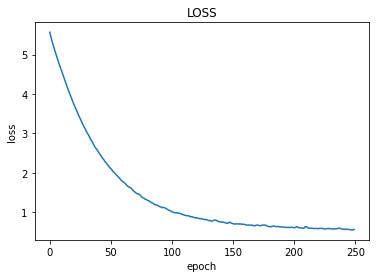

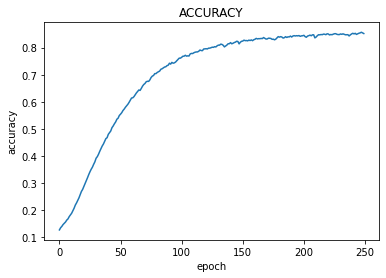

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('LOSS')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['accuracy'])
plt.title('ACCURACY')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [21]:
seed_text  = 'beyond the mountains where the wind cries out its pain'
next_words = 150
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen = MAX_SEQ_LEN - 1, padding = 'pre')
    predicted  = model.predict(token_list, verbose = 0)
    predicted  = np.argmax(predicted,axis=1)
    seed_text += ' ' + reverse_word_index[predicted[0]]
print (seed_text)

beyond the mountains where the wind cries out its pain begins the same time hence the same time hence its clouds of time i take is foreverdark danger of of great lake of its years of the man i die down the same to stretch for the songs of its feet its day and souls and the sky you ride to the sky down the same of its man invites my name down your sword is also before you sacrifice my way again i'll see you a old thing is thy who of the same of one day of richard and purifying purifying purifying blood and works of oden to the wheel of blood and ice fly and blood of the old breath of blood of as the great great material to fill the same time hence the clouds of a great part of tied in the light because to fill the grave who who of oden down the clouds
